In [1]:
!pip install aiapy 
!pip install numpydoc 

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 5.4 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.2/101.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.2/210.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 68.3 MB/s eta 0:00:00:00:0100:01
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5033 sha256=28746f169d3a791b71de444e93907ab86b52b501282a4bd0a2d46d31d68

In [2]:
!wget https://github.com/observethesun/sunspot_groups/raw/main/dataset/sunspot_dataset.zip
!unzip sunspot_dataset.zip 

--2024-09-01 23:10:42--  https://github.com/observethesun/sunspot_groups/raw/main/dataset/sunspot_dataset.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/observethesun/sunspot_groups/main/dataset/sunspot_dataset.zip [following]
--2024-09-01 23:10:42--  https://raw.githubusercontent.com/observethesun/sunspot_groups/main/dataset/sunspot_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14406615 (14M) [application/zip]
Saving to: 'sunspot_dataset.zip'

sunspot_dataset.zip 100%[===================>]  13.74M  --.-KB/s    in 0.07s   

2024-09-01 23:10:43 (203 MB/s) - 'sunspot_dataset.zip

In [3]:
import git
git.Repo.clone_from('https://github.com/observethesun/helio.git', '/kaggle/working/module_helio')

<git.repo.base.Repo '/kaggle/working/module_helio/.git'>

In [4]:
import os
import zipfile

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

import torch
import torch.optim as optim
import torchvision.models as models

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from tqdm import tqdm
import random 

import sys
sys.path.append('/kaggle/working/module_helio')

from helio import FilesIndex, HelioBatch, BatchSampler
from helio import VAE

2024-09-01 23:11:02.142207: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-01 23:11:02.142400: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-01 23:11:02.317171: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
def transform_channels(arr):
    out = (arr[..., 0] | arr[..., 2]).astype(np.float32)
    out[arr[..., 1]] = 2
    return np.expand_dims(out, 0) / 2 #normalize to [0, 1]

In [7]:
prop_emb = pd.read_csv('/kaggle/input/inv-emb/properties_embeddings.csv')
prop_emb.head(3)

,fname,date,group_number,lat_max,lat_mean,lat_min,long_max,long_mean,long_min,area,...,22,23,24,25,26,27,28,29,30,31
0,201007230452_63,2010-07-23 04:52:00,63,-20.896839,-23.565131,-26.597699,204.043367,200.328655,194.646751,489.292797,...,1.324323,0.206686,-0.773984,-0.706433,-2.542088,0.735927,-1.828404,-0.400432,1.794184,3.556576
1,201007240414_63,2010-07-24 04:14:00,63,-21.131845,-23.933526,-27.108871,204.704703,201.274268,194.511357,303.408179,...,-2.280273,0.033423,0.763244,-1.771013,-2.397232,-2.849603,1.879758,0.610913,2.046473,0.696940
2,201007250447_64,2010-07-25 04:47:00,64,23.580196,23.339903,23.101008,149.500812,149.048761,148.527835,16.553683,...,0.882444,-1.093549,-4.075765,-1.007012,-0.632858,-1.608380,3.260197,-3.865491,-2.199181,0.908257


In [8]:
df_a = prop_emb.iloc[:,:1]
df_b = prop_emb.iloc[:,17:]
inv_emb = pd.concat([df_a,df_b], axis=1)
inv_emb.head()

,fname,0,1,2,3,4,5,6,7,8,...,22,23,24,25,26,27,28,29,30,31
0,201007230452_63,-2.548106,1.181495,1.375547,-0.209886,-0.436301,0.058469,-2.751680,0.625120,1.801969,...,1.324323,0.206686,-0.773984,-0.706433,-2.542088,0.735927,-1.828404,-0.400432,1.794184,3.556576
1,201007240414_63,3.308705,1.701356,1.008363,-1.859264,2.262855,0.689745,-2.013217,1.596452,1.904591,...,-2.280273,0.033423,0.763244,-1.771013,-2.397232,-2.849603,1.879758,0.610913,2.046473,0.696940
2,201007250447_64,0.544050,3.871653,-3.011444,1.899010,1.585517,0.991888,0.255717,0.413672,2.141736,...,0.882444,-1.093549,-4.075765,-1.007012,-0.632858,-1.608380,3.260197,-3.865491,-2.199181,0.908257
3,201007250447_63,-1.362825,-0.010082,0.880551,-1.187509,1.229160,0.494770,0.262265,-0.863415,0.337300,...,0.853395,-0.443927,0.792002,0.817088,-1.461736,1.366083,0.501775,0.562915,0.865622,-0.038163
4,201007260349_63,-0.046227,1.317150,-0.152698,2.753534,0.559023,2.216889,0.822927,1.570466,1.517516,...,-0.926250,-1.676673,-0.953451,-1.084468,-0.894734,-2.140663,0.451901,-0.782241,-1.185347,1.115910


In [9]:
inv_emb.shape

(8498, 33)

In [10]:
inv_emb

,fname,0,1,2,3,4,5,6,7,8,...,22,23,24,25,26,27,28,29,30,31
0,201007230452_63,-2.548106,1.181495,1.375547,-0.209886,-0.436301,0.058469,-2.751680,0.625120,1.801969,...,1.324323,0.206686,-0.773984,-0.706433,-2.542088,0.735927,-1.828404,-0.400432,1.794184,3.556576
1,201007240414_63,3.308705,1.701356,1.008363,-1.859264,2.262855,0.689745,-2.013217,1.596452,1.904591,...,-2.280273,0.033423,0.763244,-1.771013,-2.397232,-2.849603,1.879758,0.610913,2.046473,0.696940
2,201007250447_64,0.544050,3.871653,-3.011444,1.899010,1.585517,0.991888,0.255717,0.413672,2.141736,...,0.882444,-1.093549,-4.075765,-1.007012,-0.632858,-1.608380,3.260197,-3.865491,-2.199181,0.908257
3,201007250447_63,-1.362825,-0.010082,0.880551,-1.187509,1.229160,0.494770,0.262265,-0.863415,0.337300,...,0.853395,-0.443927,0.792002,0.817088,-1.461736,1.366083,0.501775,0.562915,0.865622,-0.038163
4,201007260349_63,-0.046227,1.317150,-0.152698,2.753534,0.559023,2.216889,0.822927,1.570466,1.517516,...,-0.926250,-1.676673,-0.953451,-1.084468,-0.894734,-2.140663,0.451901,-0.782241,-1.185347,1.115910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8493,202008120532_31,0.427921,3.328786,-2.504029,1.745950,1.689185,1.116180,0.394150,0.495285,0.670753,...,0.192387,-0.752050,-2.254996,-1.003305,0.272891,-1.864372,2.097472,-2.238487,-2.617031,0.630901
8494,202008120532_33,0.532400,3.260019,-2.400629,1.307625,0.986528,0.917200,0.374893,0.359744,0.186975,...,0.232507,-0.796605,-1.784490,-0.570540,0.771004,-1.540070,1.297161,-1.416048,-2.186223,0.520979
8495,202008180351_34,1.376579,3.860616,-2.443520,2.038585,1.523588,1.054837,0.068627,-0.026125,1.345187,...,0.317950,-0.921206,-3.799561,-0.936377,-0.152293,-1.807665,3.136356,-3.436930,-1.648822,1.062316
8496,202008190344_35,0.913290,1.771041,-1.795100,1.960063,1.135854,-0.168017,-0.460432,-0.464126,0.310004,...,-0.777364,-0.128903,-0.711682,-0.417607,-0.569033,-2.126906,2.872459,-2.347538,-0.828283,0.330877


In [11]:
inv_emb2= inv_emb.set_index('fname').sort_index()
inv_emb2

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
fname,,,,,,,,,,,,,,,,,,,,,
201007230452_63,-2.548106,1.181495,1.375547,-0.209886,-0.436301,0.058469,-2.751680,0.625120,1.801969,-0.257077,...,1.324323,0.206686,-0.773984,-0.706433,-2.542088,0.735927,-1.828404,-0.400432,1.794184,3.556576
201007240414_63,3.308705,1.701356,1.008363,-1.859264,2.262855,0.689745,-2.013217,1.596452,1.904591,-0.881336,...,-2.280273,0.033423,0.763244,-1.771013,-2.397232,-2.849603,1.879758,0.610913,2.046473,0.696940
201007250447_63,-1.362825,-0.010082,0.880551,-1.187509,1.229160,0.494770,0.262265,-0.863415,0.337300,-0.723508,...,0.853395,-0.443927,0.792002,0.817088,-1.461736,1.366083,0.501775,0.562915,0.865622,-0.038163
201007250447_64,0.544050,3.871653,-3.011444,1.899010,1.585517,0.991888,0.255717,0.413672,2.141736,0.681359,...,0.882444,-1.093549,-4.075765,-1.007012,-0.632858,-1.608380,3.260197,-3.865491,-2.199181,0.908257
201007260349_63,-0.046227,1.317150,-0.152698,2.753534,0.559023,2.216889,0.822927,1.570466,1.517516,-0.887935,...,-0.926250,-1.676673,-0.953451,-1.084468,-0.894734,-2.140663,0.451901,-0.782241,-1.185347,1.115910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202008120532_31,0.427921,3.328786,-2.504029,1.745950,1.689185,1.116180,0.394150,0.495285,0.670753,0.428450,...,0.192387,-0.752050,-2.254996,-1.003305,0.272891,-1.864372,2.097472,-2.238487,-2.617031,0.630901
202008120532_33,0.532400,3.260019,-2.400629,1.307625,0.986528,0.917200,0.374893,0.359744,0.186975,0.729678,...,0.232507,-0.796605,-1.784490,-0.570540,0.771004,-1.540070,1.297161,-1.416048,-2.186223,0.520979
202008180351_34,1.376579,3.860616,-2.443520,2.038585,1.523588,1.054837,0.068627,-0.026125,1.345187,1.015935,...,0.317950,-0.921206,-3.799561,-0.936377,-0.152293,-1.807665,3.136356,-3.436930,-1.648822,1.062316


In [12]:
pca = PCA(n_components=2, random_state=0)
emb_pca = pca.fit_transform(inv_emb2)

In [13]:
fig = px.scatter(
    emb_pca, x=0, y=1,
    labels={'color': 'species'},
    color=labels
)
fig.update_traces(marker_size=5)
fig.show()

NameError: name 'labels' is not defined

In [14]:
tsne = TSNE(n_components=2, random_state=0, perplexity=30)
inv_emb_tsne = tsne.fit_transform(inv_emb2)

In [16]:
fig = px.scatter(
    inv_emb_tsne, x=0, y=1,
    labels={'color': 'species'},
    color_continuous_scale='turbo',
    color=labels
)
fig.update_traces(marker_size=5)
fig.show()

In [40]:
emb_pca.shape

(8498, 2)

In [20]:
pca_3_comp = PCA(n_components=3, random_state=0)
emb_pca_3_comp = pca_3_comp.fit_transform(inv_emb2)

In [43]:
pca_3_comp = PCA(n_components=3, random_state=0)
emb_pca_3_comp = pca_3_comp.fit_transform(inv_emb2)

tsne2 = TSNE(n_components=2, random_state=0, perplexity=30)
inv_emb_tsne2 = tsne.fit_transform(emb_pca_3_comp)
fig = px.scatter(
    inv_emb_tsne, x=0, y=1,
    labels={'color': 'species'},
    color_continuous_scale='turbo',
    color=labels
)
fig.update_traces(marker_size=5)
fig.show()

In [44]:
tsne = TSNE(n_components=3, random_state=0, perplexity=30)
inv_emb_tsne = tsne.fit_transform(emb_pca_3_comp)
#point_names = df_values.index.tolist()
fig = go.Figure(data=[go.Scatter3d(
    x=inv_emb_tsne[:, 0],
    y=inv_emb_tsne[:, 1],
    z=inv_emb_tsne[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color=labels,
        colorscale='turbo',
        opacity=0.8
    ),
    #hovertext=[f'{point_names[i]}' for i in range(len(inv_emb_tsne))],
    #hoverinfo='text'
)])

fig.show()

In [13]:
emb_pca.shape

(8498, 2)

In [14]:
inv_emb2.iloc[[7783, 3632, 529, 1741, 10]]

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
fname,,,,,,,,,,,,,,,,,,,,,
201609080432_153,1.808113,2.367071,-1.930359,0.792491,1.510002,-0.154462,0.586570,0.375238,0.824163,0.554666,...,0.910614,-0.170464,-1.902184,-0.401101,-0.100482,-3.185047,2.403703,-3.250476,-1.290621,-0.208811
201307050428_202,1.213567,1.947553,-1.308708,1.621140,0.769119,-0.472962,-0.526950,-0.003992,1.155503,-0.473110,...,0.225247,-0.837911,-1.315125,-0.874084,0.918285,-0.904054,0.785169,-0.610580,-1.734940,0.223709
201105090705_84,3.933505,5.141173,0.152070,-1.812531,-0.597307,-0.430941,-2.140639,1.283469,1.848449,-1.039926,...,-0.633021,0.806137,-4.379774,-1.368143,-0.392364,-3.272682,-0.460557,-1.588949,1.213776,-1.489486
201203260529_79,-3.859486,0.066372,1.374376,3.250429,2.994466,-0.024949,2.239838,1.157473,-3.010295,-1.226541,...,-1.217330,-0.148958,-0.033980,-1.669258,-0.365711,0.015191,1.817902,-0.624977,-2.277199,0.821800
201008010408_65,-4.487675,-2.263355,-0.248109,4.222947,2.937179,-0.632883,-0.612513,0.286214,-2.470069,-2.439457,...,-0.267133,-0.255748,1.548580,-0.286761,-1.800659,-4.122788,0.815437,-2.975992,-1.002548,1.578379


In [28]:
hier_clust.shape

(8497, 4)

In [23]:
hier_clust[-15:, 2]

array([ 56.4651189 ,  62.13973086,  69.67316075,  76.10713109,
        81.46281529,  81.78597758,  84.87354334, 100.21864043,
       125.19484725, 137.46956604, 152.75571521, 208.8926382 ,
       291.10518019, 379.03061907, 490.79315485])

In [15]:
hier_clust = linkage(emb_pca, method='ward')
distances = hier_clust[-15:, 2]
distances_sorted = sorted(distances, reverse=True)
hier_clust_labels = fcluster(hier_clust, t=distances_sorted[6], criterion='distance')
len(set(hier_clust_labels))

7

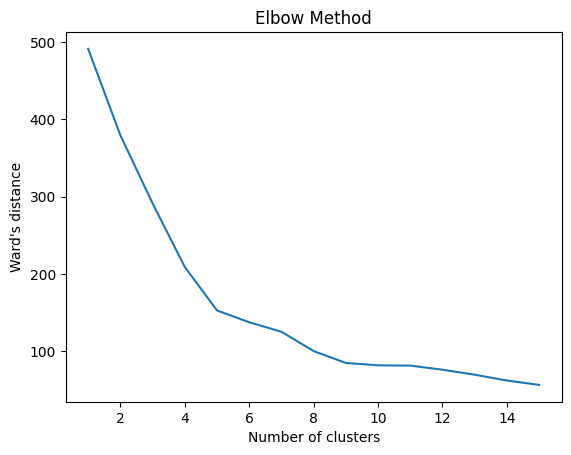

In [20]:
#plt.figure(figsize=(10, 7))
plt.plot(range(1, len(distances_sorted) + 1), distances_sorted)
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("Ward's distance")
plt.show()

In [15]:
set(hier_clust_labels)

{1, 2, 3, 4, 5, 6, 7}

In [16]:
clusters = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []}
for index, label in enumerate(hier_clust_labels):
    #print('img:',index, 'label:',label)
    for i in range(1, 8):
        if label == i:  #i-1(если labels [0,...,6]), i(если labels [1,...,7])
            clusters[i].append(index)

In [24]:
# выбираем случайным образом по 5 точек в каждый кластер
num_clusts = []
sampled_clusters = {}
x = 0
for cluster_num, indices in clusters.items():
    sampled_clusters[cluster_num] = random.choices(indices, k=5) #indices[0:5]   random.choices(indices, k=5)
    #print(f"Кластер {cluster_num}. Элементов: {len(indices)}")
    x += len(indices)
    num_clusts.append(len(indices))
print(x == 8498)  
sampled_clusters

True


{1: [7240, 5902, 7878, 7393, 2448],
 2: [7020, 5580, 654, 413, 5715],
 3: [6693, 4904, 7496, 4271, 5383],
 4: [4514, 4059, 8326, 8011, 6205],
 5: [2063, 7716, 127, 5583, 221],
 6: [6047, 5412, 2593, 2552, 5701],
 7: [2364, 5524, 2134, 5205, 6896]}

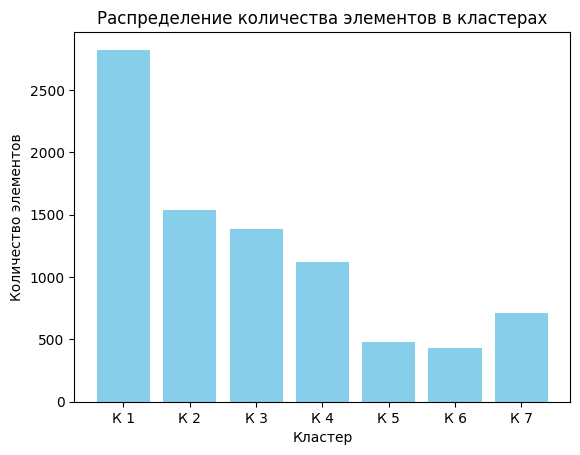

In [25]:
plt.bar(range(len(num_clusts)), num_clusts, color='skyblue')
plt.xlabel('Кластер')
plt.ylabel('Количество элементов')
plt.title('Распределение количества элементов в кластерах')
plt.xticks(range(len(num_clusts)), [f'К {i+1}' for i in range(len(num_clusts))])
plt.show()

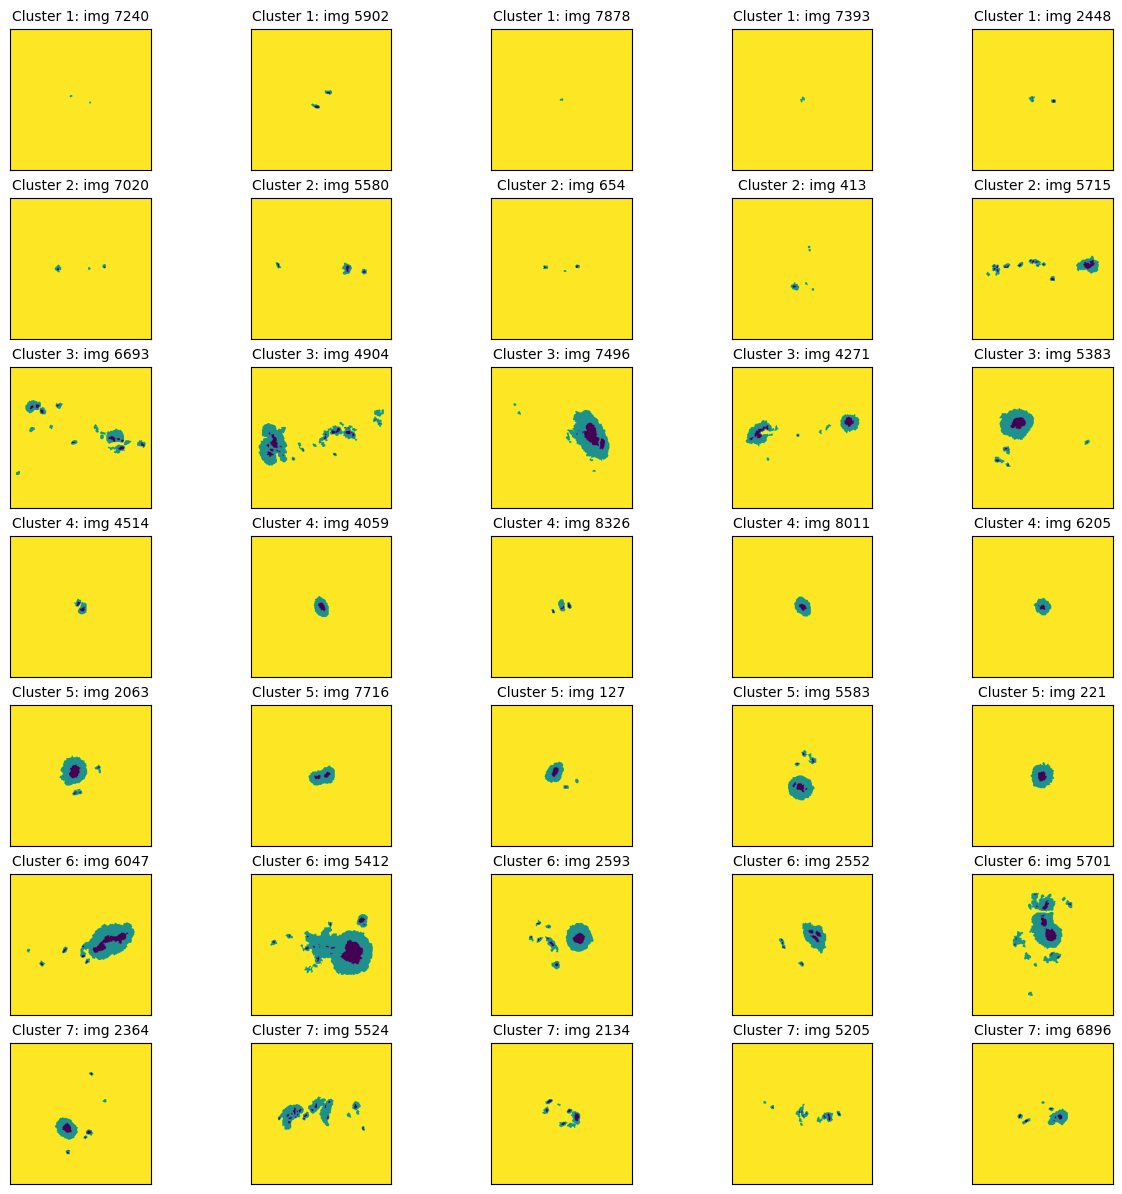

In [26]:
index = FilesIndex(path='/kaggle/working/sunspot_dataset/*.npz', name='img').sort_index()
fig, ax = plt.subplots(len(set(hier_clust_labels)), len(sampled_clusters[1]), figsize=(15, 15))
fig.patch.set_facecolor('xkcd:white')

for i, (key, color_clust) in enumerate(sampled_clusters.items()):
    with torch.no_grad():
        batch = (HelioBatch(index.iloc[color_clust])
                 .load('img', sparse=True)
                 .apply(lambda x: x.toarray().reshape(256, 256, 3), src='img')
                 .apply(transform_channels, src='img'))
        x = torch.tensor(np.stack(batch.img)).to(device)

    for j in range(len(sampled_clusters[1])):
        ax[i][j].imshow(1-x[j,0].detach().cpu().numpy(),vmin=0, vmax=1)
        ax[i][j].set_title('Cluster {}: img {}'.format(key, color_clust[j]), fontsize=10)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

plt.show()

# 5 кластеров

In [27]:
hier_clust = linkage(emb_pca, method='ward')
distances = hier_clust[-15:, 2]
distances_sorted = sorted(distances, reverse=True)
hier_clust_labels = fcluster(hier_clust, t=distances_sorted[4], criterion='distance')
len(set(hier_clust_labels))

5

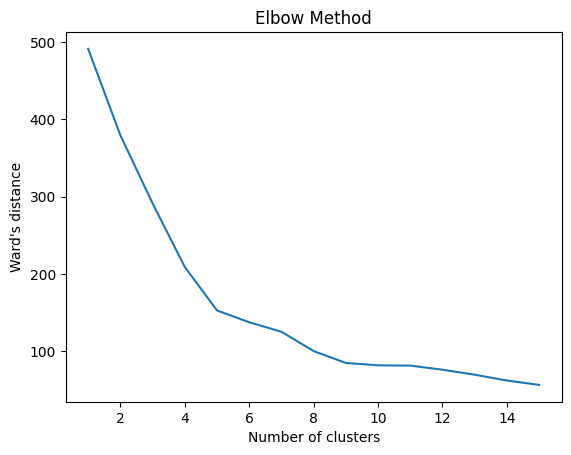

In [28]:
#plt.figure(figsize=(10, 7))
plt.plot(range(1, len(distances_sorted) + 1), distances_sorted)
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("Ward's distance")
plt.show()

In [29]:
clusters = {1: [], 2: [], 3: [], 4: [], 5: []}
for index, label in enumerate(hier_clust_labels):
    #print('img:',index, 'label:',label)
    for i in range(1, 6):
        if label == i:  #i-1(если labels [0,...,6]), i(если labels [1,...,7])
            clusters[i].append(index)

In [30]:
# выбираем случайным образом по 5 точек в каждый кластер
num_clusts = []
sampled_clusters = {}
x = 0
for cluster_num, indices in clusters.items():
    sampled_clusters[cluster_num] = random.choices(indices, k=5) #indices[0:5]   random.choices(indices, k=5)
    #print(f"Кластер {cluster_num}. Элементов: {len(indices)}")
    x += len(indices)
    num_clusts.append(len(indices))
print(x == 8498)  
sampled_clusters

True


{1: [5753, 6550, 3924, 2316, 7860],
 2: [3678, 290, 2739, 5655, 1026],
 3: [5029, 2041, 4747, 5926, 4316],
 4: [5837, 4919, 5305, 6504, 7694],
 5: [6906, 8109, 1029, 6295, 2580]}

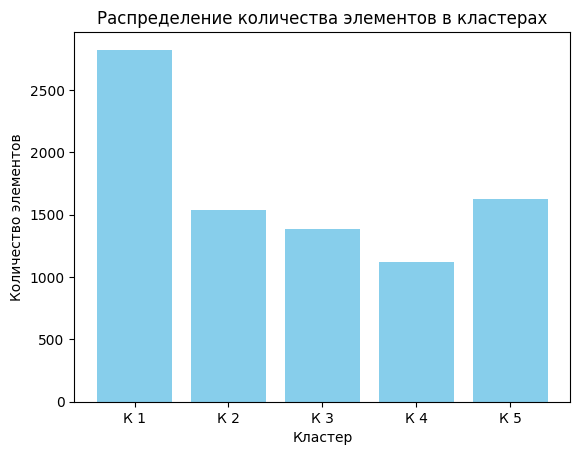

In [31]:
plt.bar(range(len(num_clusts)), num_clusts, color='skyblue')
plt.xlabel('Кластер')
plt.ylabel('Количество элементов')
plt.title('Распределение количества элементов в кластерах')
plt.xticks(range(len(num_clusts)), [f'К {i+1}' for i in range(len(num_clusts))])
plt.show()

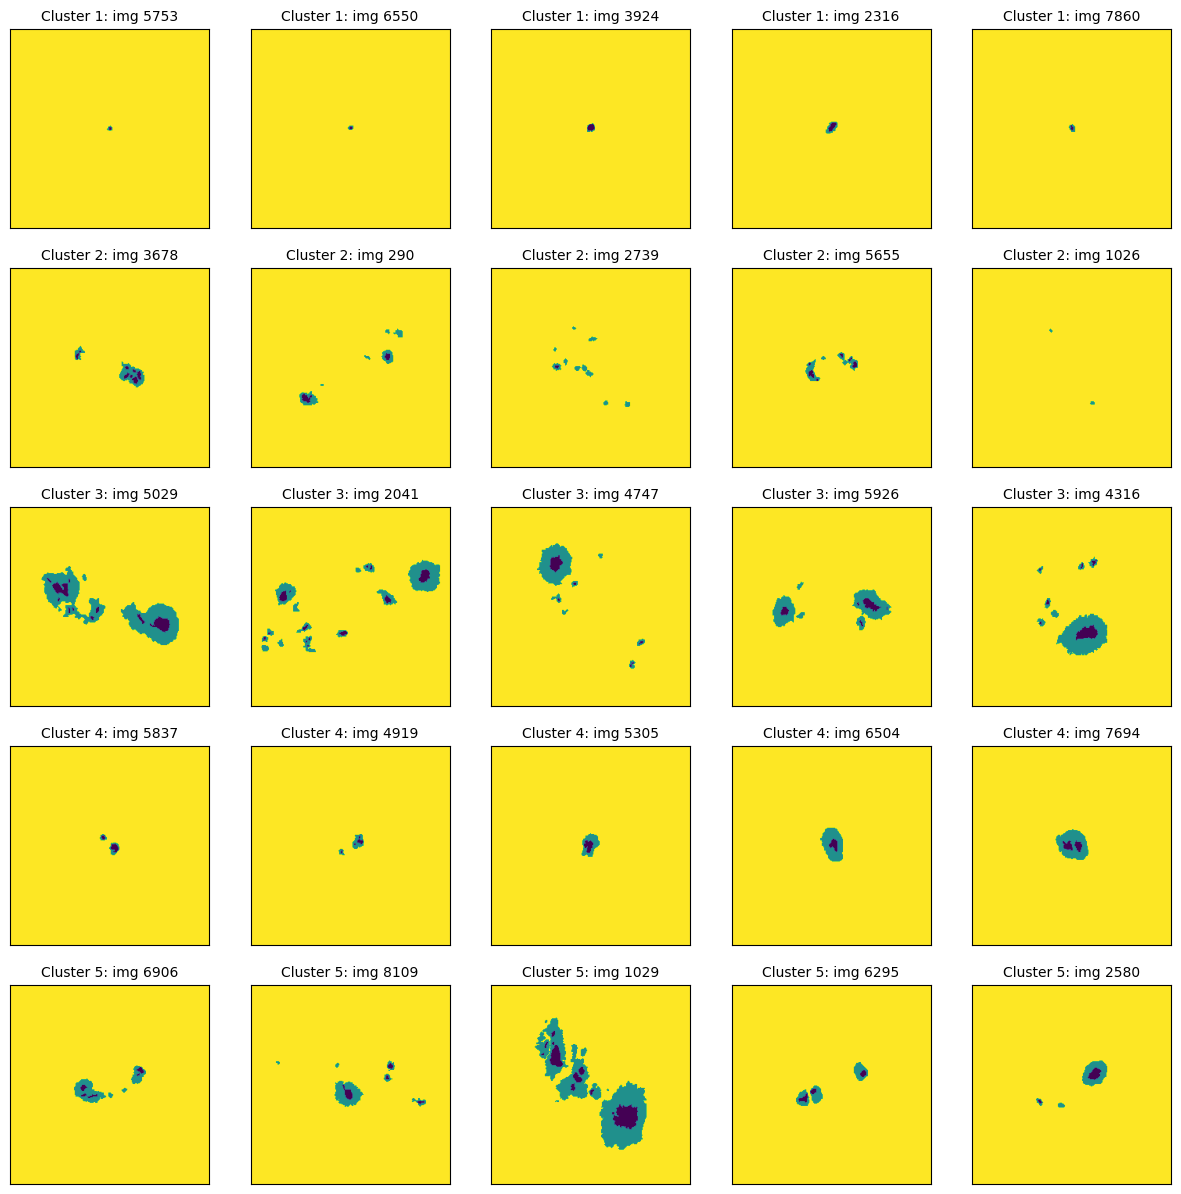

In [32]:
index = FilesIndex(path='/kaggle/working/sunspot_dataset/*.npz', name='img').sort_index()
fig, ax = plt.subplots(len(set(hier_clust_labels)), len(sampled_clusters[1]), figsize=(15, 15))
fig.patch.set_facecolor('xkcd:white')

for i, (key, color_clust) in enumerate(sampled_clusters.items()):
    with torch.no_grad():
        batch = (HelioBatch(index.iloc[color_clust])
                 .load('img', sparse=True)
                 .apply(lambda x: x.toarray().reshape(256, 256, 3), src='img')
                 .apply(transform_channels, src='img'))
        x = torch.tensor(np.stack(batch.img)).to(device)

    for j in range(len(sampled_clusters[1])):
        ax[i][j].imshow(1-x[j,0].detach().cpu().numpy(),vmin=0, vmax=1)
        ax[i][j].set_title('Cluster {}: img {}'.format(key, color_clust[j]), fontsize=10)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

plt.show()

# 9 кластеров

In [16]:
hier_clust = linkage(emb_pca, method='ward')
distances = hier_clust[-15:, 2]
distances_sorted = sorted(distances, reverse=True)
hier_clust_labels = fcluster(hier_clust, t=distances_sorted[8], criterion='distance')
len(set(hier_clust_labels))

9

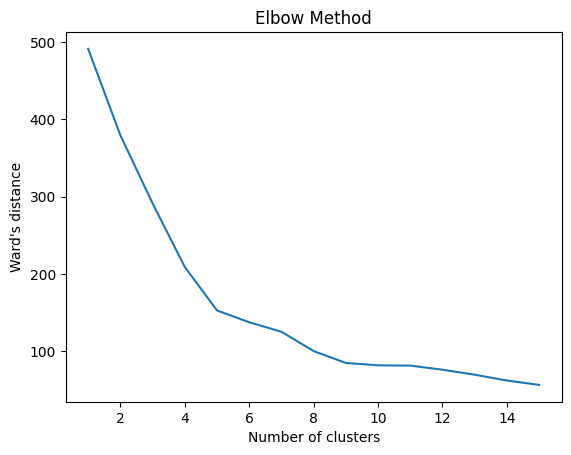

In [17]:
#plt.figure(figsize=(10, 7))
plt.plot(range(1, len(distances_sorted) + 1), distances_sorted)
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("Ward's distance")
plt.show()

In [25]:
tsne = TSNE(n_components=3, random_state=0, perplexity=30)
inv_emb_tsne = tsne.fit_transform(emb_pca_3_comp)
#point_names = df_values.index.tolist()
fig = go.Figure(data=[go.Scatter3d(
    x=inv_emb_tsne[:, 0],
    y=inv_emb_tsne[:, 1],
    z=inv_emb_tsne[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color=hier_clust_labels,
        colorscale='turbo',
        opacity=0.8
    ),
    #hovertext=[f'{point_names[i]}' for i in range(len(inv_emb_tsne))],
    #hoverinfo='text'
)])

fig.show()

In [34]:
clusters = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
for index, label in enumerate(hier_clust_labels):
    #print('img:',index, 'label:',label)
    for i in range(1, 10):
        if label == i:  #i-1(если labels [0,...,6]), i(если labels [1,...,7])
            clusters[i].append(index)

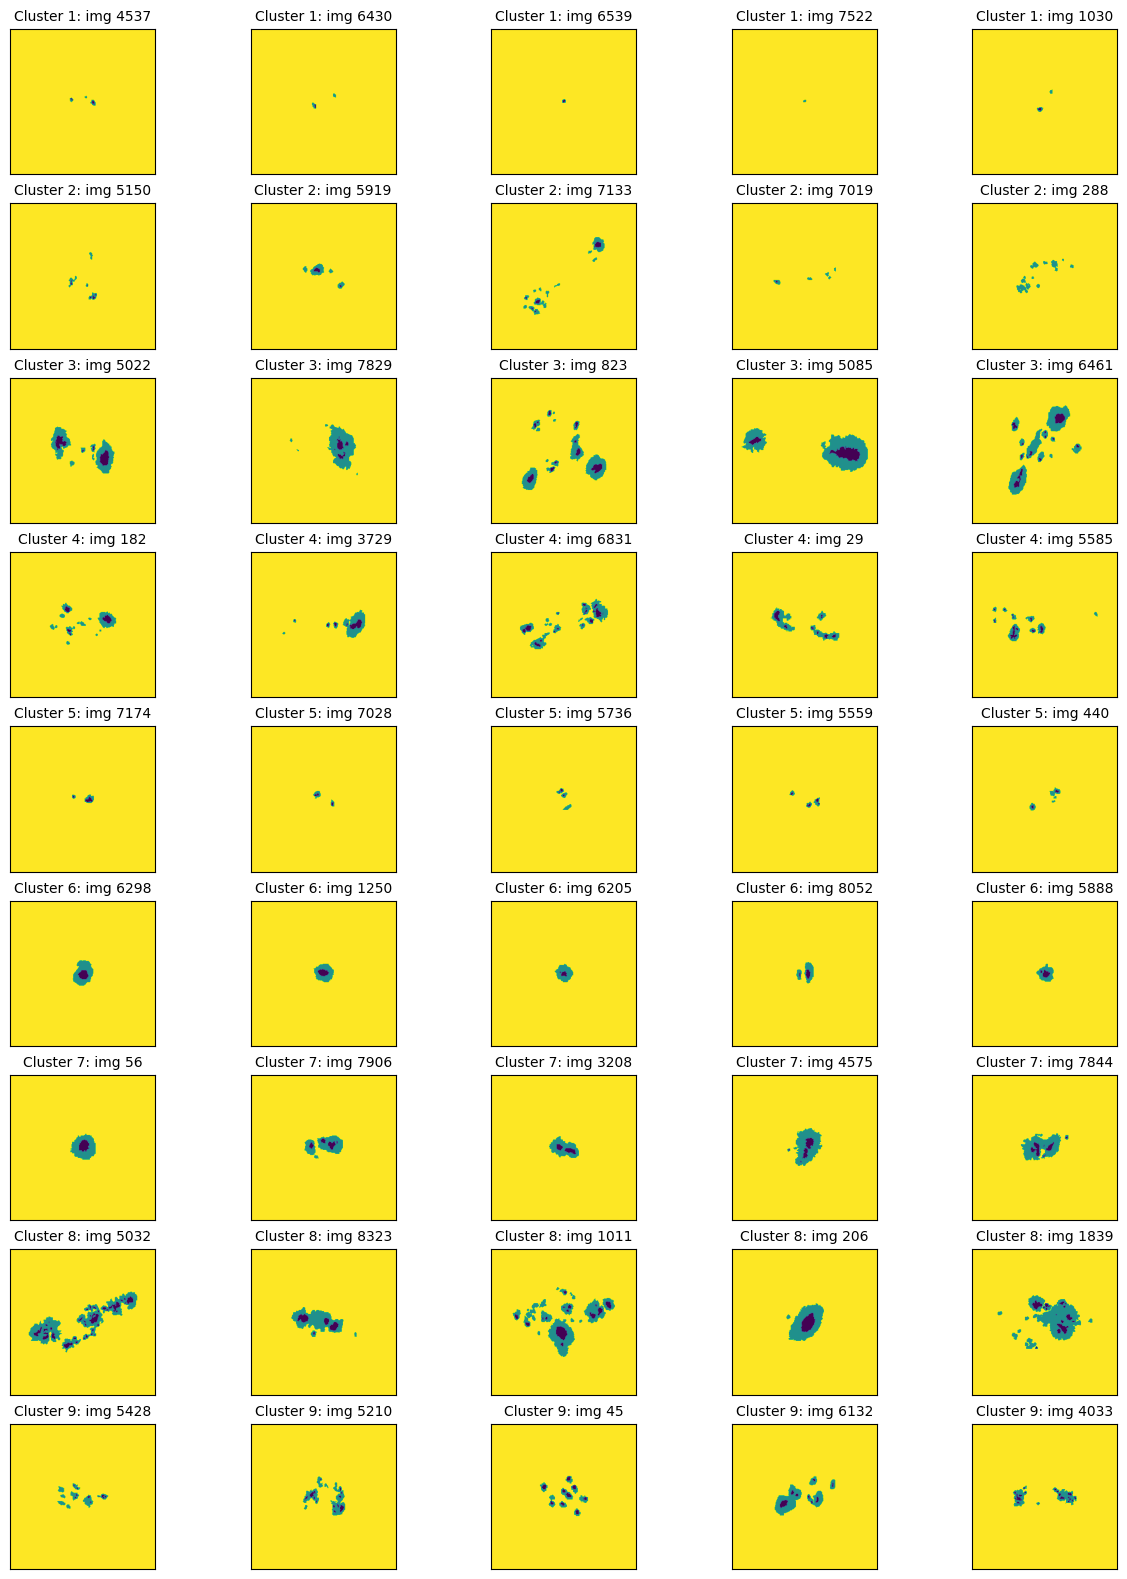

In [42]:
# выбираем случайным образом по 5 точек в каждый кластер
num_clusts = []
sampled_clusters = {}
x = 0
for cluster_num, indices in clusters.items():
    sampled_clusters[cluster_num] = random.choices(indices, k=5) #indices[0:5]   random.choices(indices, k=5)
    #print(f"Кластер {cluster_num}. Элементов: {len(indices)}")
    x += len(indices)
    num_clusts.append(len(indices))

index = FilesIndex(path='/kaggle/working/sunspot_dataset/*.npz', name='img').sort_index()
fig, ax = plt.subplots(len(set(hier_clust_labels)), len(sampled_clusters[1]), figsize=(15, 20))
fig.patch.set_facecolor('xkcd:white')

for i, (key, color_clust) in enumerate(sampled_clusters.items()):
    with torch.no_grad():
        batch = (HelioBatch(index.iloc[color_clust])
                 .load('img', sparse=True)
                 .apply(lambda x: x.toarray().reshape(256, 256, 3), src='img')
                 .apply(transform_channels, src='img'))
        x = torch.tensor(np.stack(batch.img)).to(device)

    for j in range(len(sampled_clusters[1])):
        ax[i][j].imshow(1-x[j,0].detach().cpu().numpy(),vmin=0, vmax=1)
        ax[i][j].set_title('Cluster {}: img {}'.format(key, color_clust[j]), fontsize=10)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

plt.show()


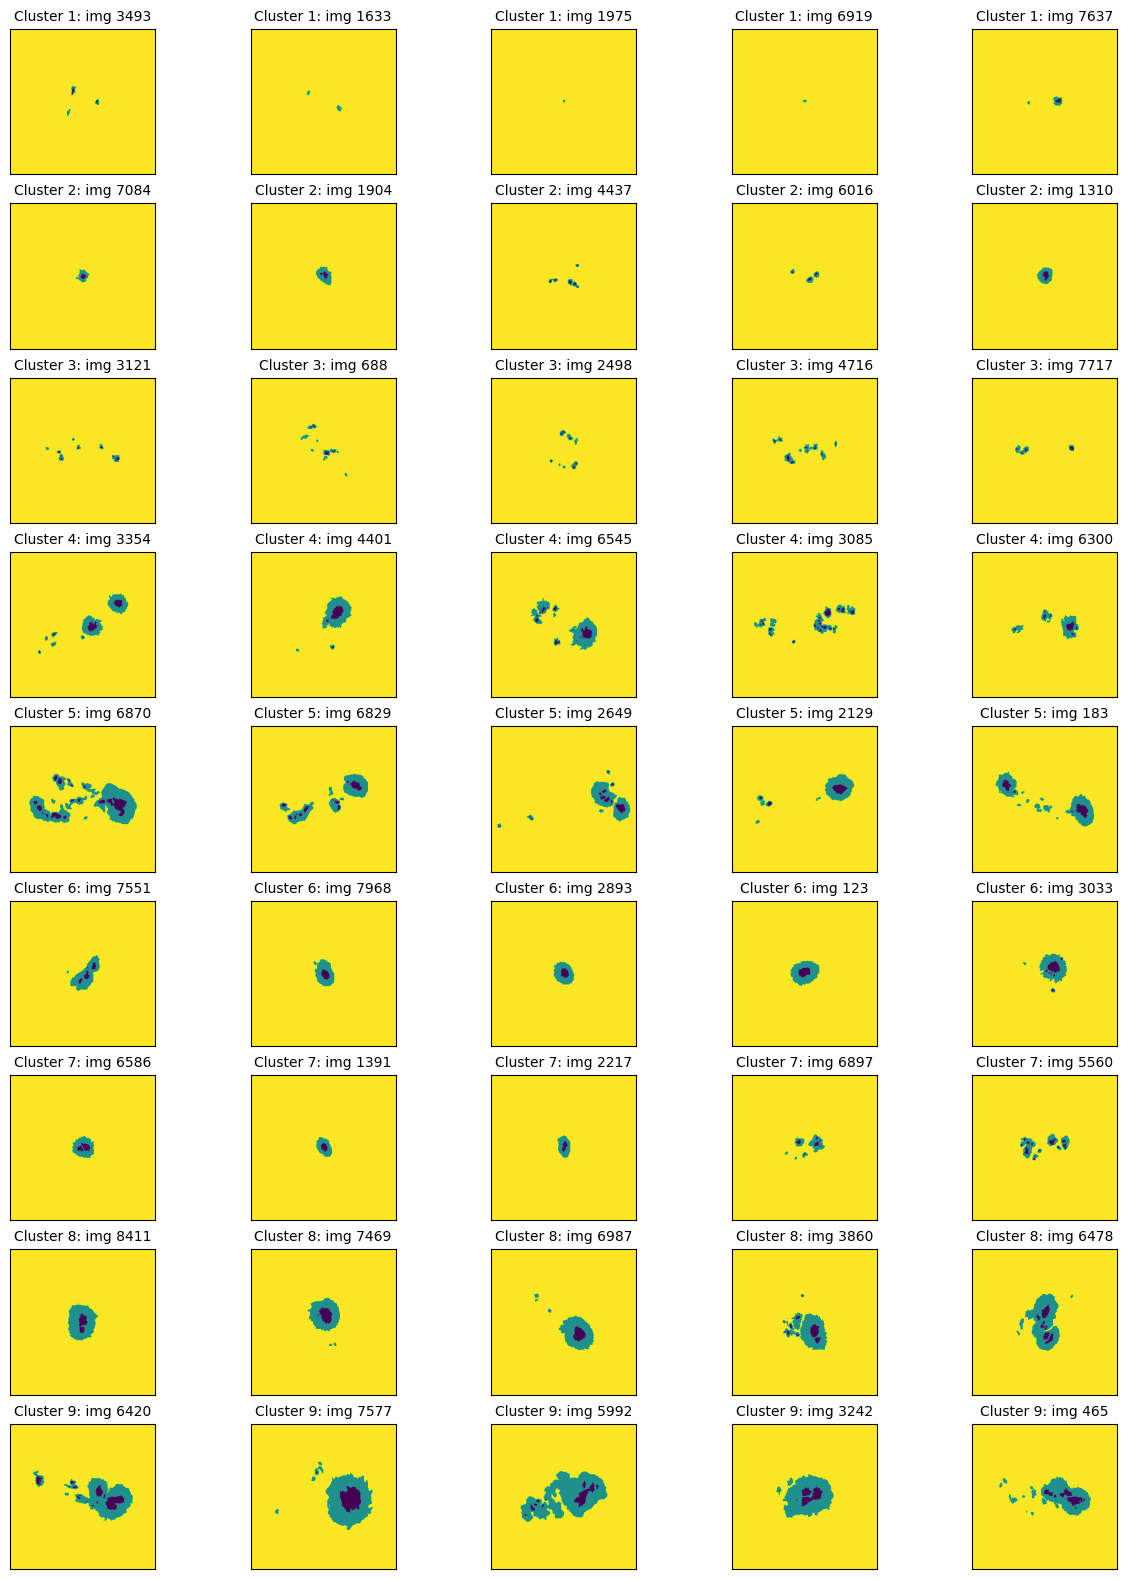

In [44]:
hier_clust = linkage(emb_pca, method='average')
distances = hier_clust[-15:, 2]
distances_sorted = sorted(distances, reverse=True)
hier_clust_labels = fcluster(hier_clust, t=distances_sorted[8], criterion='distance')

clusters = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
for index, label in enumerate(hier_clust_labels):
    #print('img:',index, 'label:',label)
    for i in range(1, 10):
        if label == i:  #i-1(если labels [0,...,6]), i(если labels [1,...,7])
            clusters[i].append(index)
# выбираем случайным образом по 5 точек в каждый кластер
num_clusts = []
sampled_clusters = {}
x = 0
for cluster_num, indices in clusters.items():
    sampled_clusters[cluster_num] = random.choices(indices, k=5) #indices[0:5]   random.choices(indices, k=5)
    #print(f"Кластер {cluster_num}. Элементов: {len(indices)}")
    x += len(indices)
    num_clusts.append(len(indices))

index = FilesIndex(path='/kaggle/working/sunspot_dataset/*.npz', name='img').sort_index()
fig, ax = plt.subplots(len(set(hier_clust_labels)), len(sampled_clusters[1]), figsize=(15, 20))
fig.patch.set_facecolor('xkcd:white')

for i, (key, color_clust) in enumerate(sampled_clusters.items()):
    with torch.no_grad():
        batch = (HelioBatch(index.iloc[color_clust])
                 .load('img', sparse=True)
                 .apply(lambda x: x.toarray().reshape(256, 256, 3), src='img')
                 .apply(transform_channels, src='img'))
        x = torch.tensor(np.stack(batch.img)).to(device)

    for j in range(len(sampled_clusters[1])):
        ax[i][j].imshow(1-x[j,0].detach().cpu().numpy(),vmin=0, vmax=1)
        ax[i][j].set_title('Cluster {}: img {}'.format(key, color_clust[j]), fontsize=10)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

plt.show()

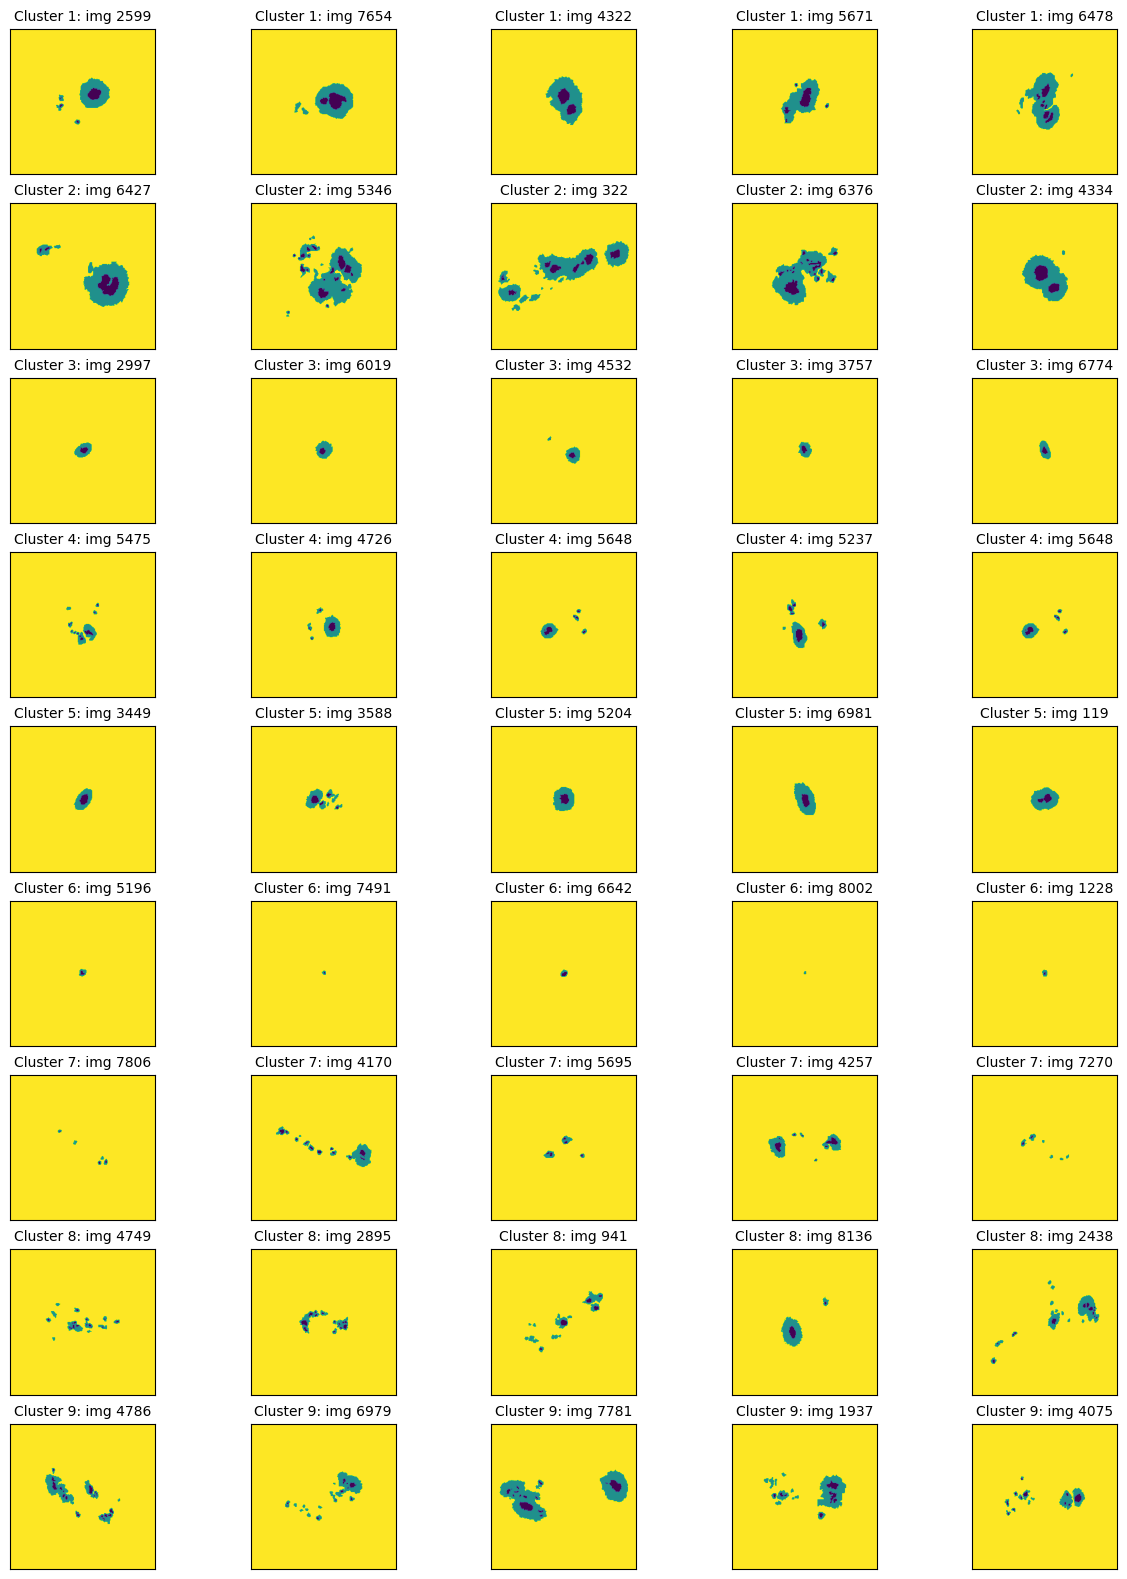

In [47]:
hier_clust = linkage(emb_pca, method='centroid')
distances = hier_clust[-15:, 2]
distances_sorted = sorted(distances, reverse=True)
hier_clust_labels = fcluster(hier_clust, t=distances_sorted[8], criterion='distance')

clusters = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
for index, label in enumerate(hier_clust_labels):
    #print('img:',index, 'label:',label)
    for i in range(1, 10):
        if label == i:  #i-1(если labels [0,...,6]), i(если labels [1,...,7])
            clusters[i].append(index)
# выбираем случайным образом по 5 точек в каждый кластер
num_clusts = []
sampled_clusters = {}
x = 0
for cluster_num, indices in clusters.items():
    sampled_clusters[cluster_num] = random.choices(indices, k=5) #indices[0:5]   random.choices(indices, k=5)
    #print(f"Кластер {cluster_num}. Элементов: {len(indices)}")
    x += len(indices)
    num_clusts.append(len(indices))

index = FilesIndex(path='/kaggle/working/sunspot_dataset/*.npz', name='img').sort_index()
fig, ax = plt.subplots(len(set(hier_clust_labels)), len(sampled_clusters[1]), figsize=(15, 20))
fig.patch.set_facecolor('xkcd:white')

for i, (key, color_clust) in enumerate(sampled_clusters.items()):
    with torch.no_grad():
        batch = (HelioBatch(index.iloc[color_clust])
                 .load('img', sparse=True)
                 .apply(lambda x: x.toarray().reshape(256, 256, 3), src='img')
                 .apply(transform_channels, src='img'))
        x = torch.tensor(np.stack(batch.img)).to(device)

    for j in range(len(sampled_clusters[1])):
        ax[i][j].imshow(1-x[j,0].detach().cpu().numpy(),vmin=0, vmax=1)
        ax[i][j].set_title('Cluster {}: img {}'.format(key, color_clust[j]), fontsize=10)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

plt.show()

In [57]:
cluster_ar = linkage(emb_pca, method='ward', metric='euclidean')
link_df = pd.DataFrame(cluster_ar, index=[f'clust {i+1}' for i,_ in enumerate(cluster_ar, start=cluster_ar.shape[0])],
                       columns=['cluster1', 'cluster2', 'dist', 'number elements'])

display(link_df)

,cluster1,cluster2,dist,number elements
clust 8498,2712.0,7588.0,0.000158,2.0
clust 8499,2334.0,6125.0,0.000224,2.0
clust 8500,1092.0,4573.0,0.000226,2.0
clust 8501,2180.0,8148.0,0.000246,2.0
clust 8502,3008.0,3527.0,0.000331,2.0
...,...,...,...,...
clust 16990,16978.0,16989.0,152.755715,1625.0
clust 16991,16984.0,16987.0,208.892638,2925.0
clust 16992,16988.0,16990.0,291.105180,2749.0
clust 16993,16991.0,16992.0,379.030619,5674.0


In [58]:
link_df['dist'].quantile(.8)

0.4052751466157158

In [59]:
from scipy.cluster.hierarchy import inconsistent

inconsistency_df = pd.DataFrame(inconsistent(cluster_ar), index=[f'clust {i+1}' for i,_ in enumerate(cluster_ar, start=cluster_ar.shape[0])],
                       columns=['mean', 'std', 'num_links', 'coef'])
display(inconsistency_df)

,mean,std,num_links,coef
clust 8498,0.000158,0.000000,1.0,0.000000
clust 8499,0.000224,0.000000,1.0,0.000000
clust 8500,0.000226,0.000000,1.0,0.000000
clust 8501,0.000246,0.000000,1.0,0.000000
clust 8502,0.000331,0.000000,1.0,0.000000
...,...,...,...,...
clust 16990,111.026192,59.532131,3.0,0.700958
clust 16991,130.191365,68.799441,3.0,1.143923
clust 16992,189.685248,88.906706,3.0,1.140746
clust 16993,293.009479,85.084975,3.0,1.011003


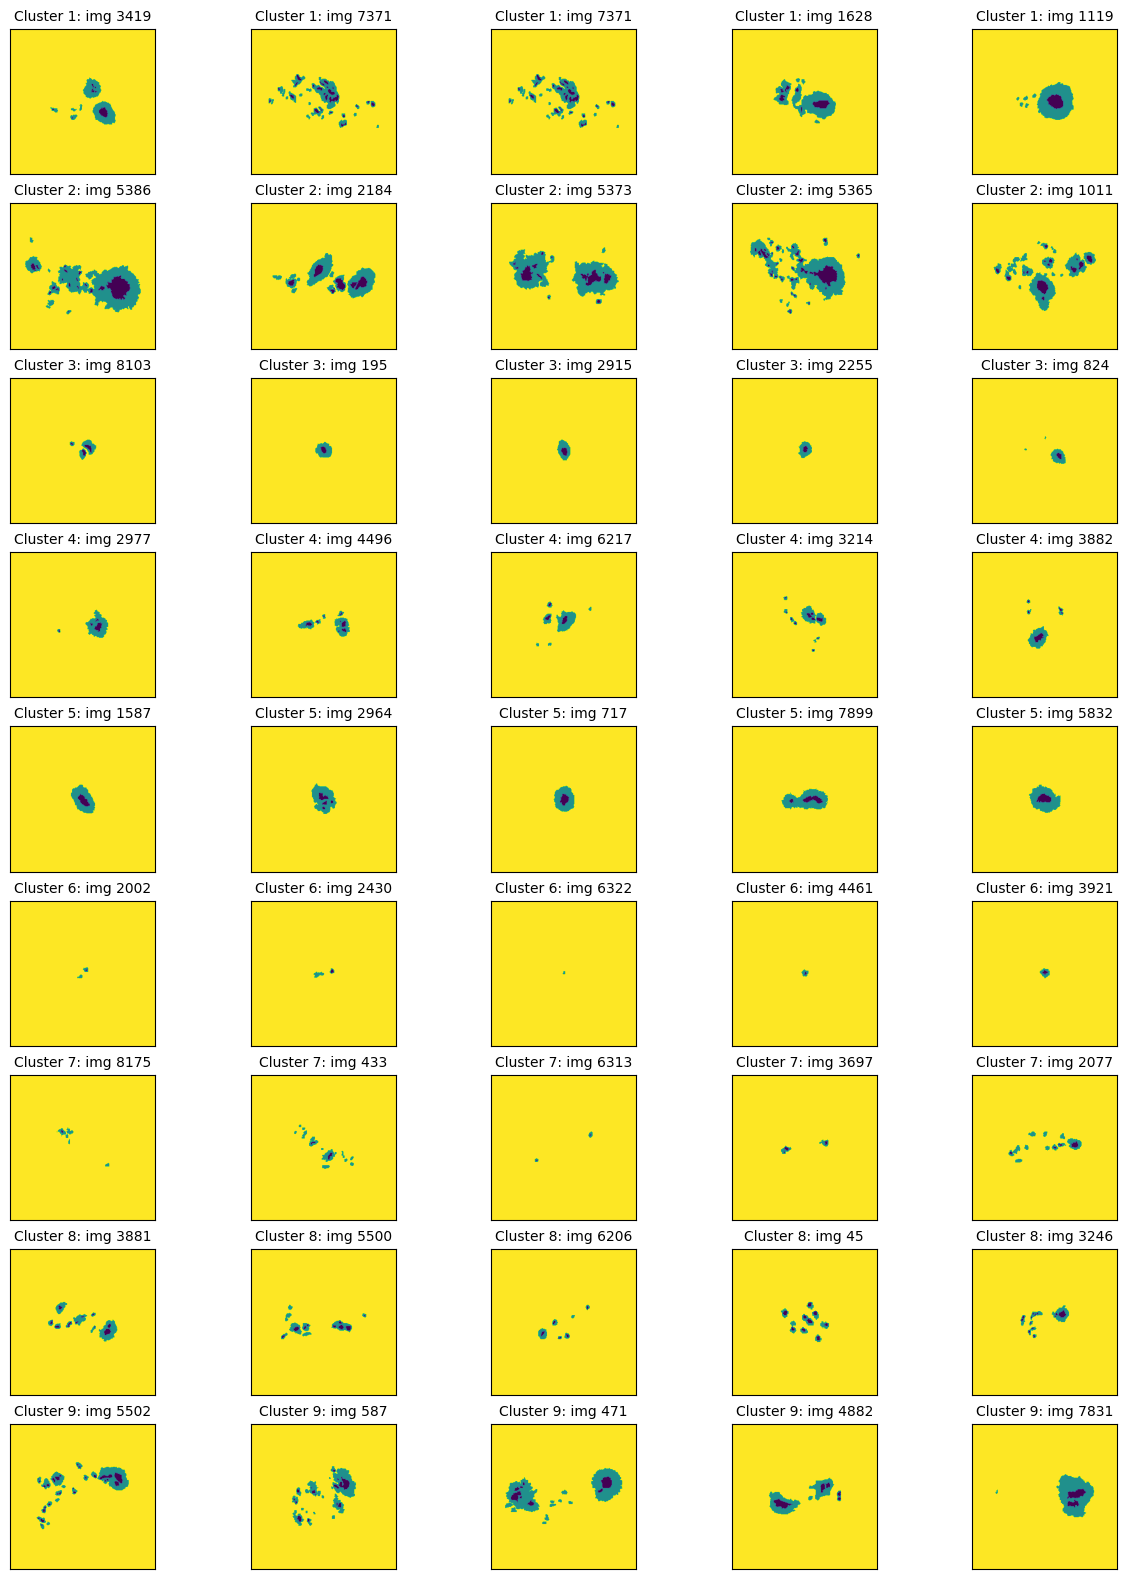

In [56]:
hier_clust = linkage(emb_pca, method='centroid')
distances = hier_clust[-15:, 2]
distances_sorted = sorted(distances, reverse=True)
hier_clust_labels = fcluster(hier_clust, t=9, criterion='maxclust')

clusters = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
for index, label in enumerate(hier_clust_labels):
    #print('img:',index, 'label:',label)
    for i in range(1, 10):
        if label == i:  #i-1(если labels [0,...,6]), i(если labels [1,...,7])
            clusters[i].append(index)
# выбираем случайным образом по 5 точек в каждый кластер
num_clusts = []
sampled_clusters = {}
x = 0
for cluster_num, indices in clusters.items():
    sampled_clusters[cluster_num] = random.choices(indices, k=5) #indices[0:5]   random.choices(indices, k=5)
    #print(f"Кластер {cluster_num}. Элементов: {len(indices)}")
    x += len(indices)
    num_clusts.append(len(indices))

index = FilesIndex(path='/kaggle/working/sunspot_dataset/*.npz', name='img').sort_index()
fig, ax = plt.subplots(len(set(hier_clust_labels)), len(sampled_clusters[1]), figsize=(15, 20))
fig.patch.set_facecolor('xkcd:white')

for i, (key, color_clust) in enumerate(sampled_clusters.items()):
    with torch.no_grad():
        batch = (HelioBatch(index.iloc[color_clust])
                 .load('img', sparse=True)
                 .apply(lambda x: x.toarray().reshape(256, 256, 3), src='img')
                 .apply(transform_channels, src='img'))
        x = torch.tensor(np.stack(batch.img)).to(device)

    for j in range(len(sampled_clusters[1])):
        ax[i][j].imshow(1-x[j,0].detach().cpu().numpy(),vmin=0, vmax=1)
        ax[i][j].set_title('Cluster {}: img {}'.format(key, color_clust[j]), fontsize=10)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

plt.show()

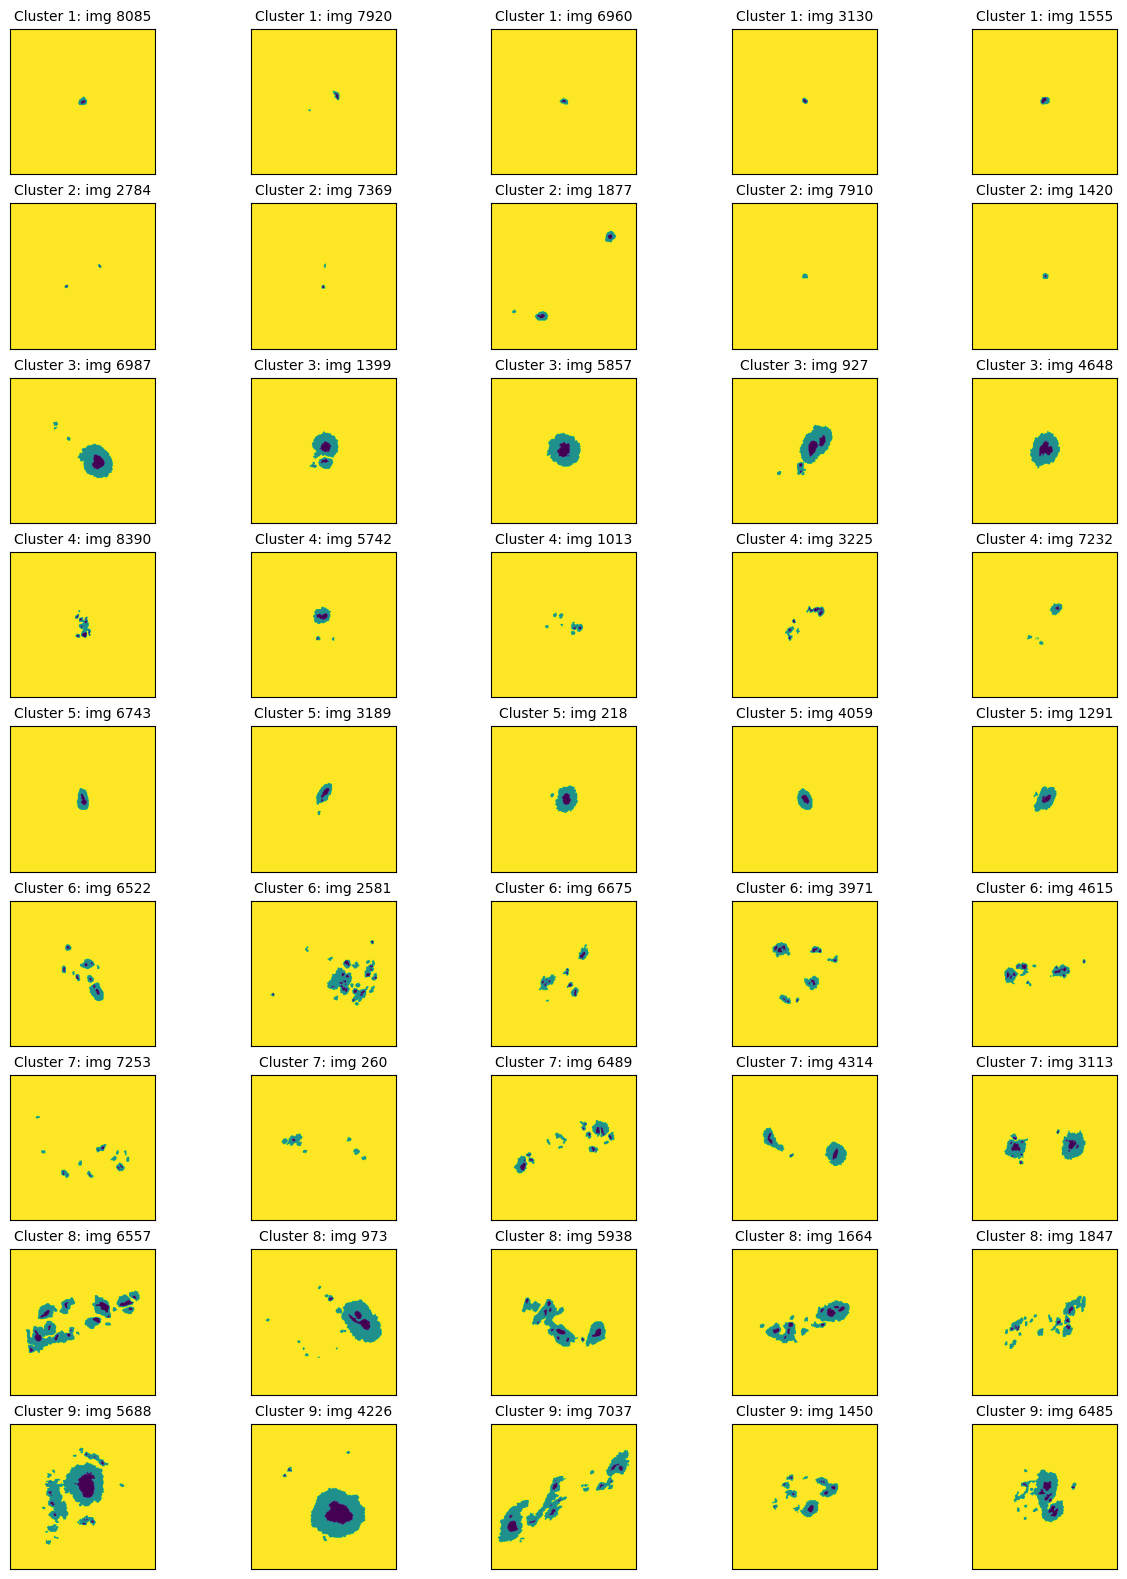

In [48]:
hier_clust = linkage(emb_pca, method='median')
distances = hier_clust[-15:, 2]
distances_sorted = sorted(distances, reverse=True)
hier_clust_labels = fcluster(hier_clust, t=distances_sorted[8], criterion='distance')

clusters = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
for index, label in enumerate(hier_clust_labels):
    #print('img:',index, 'label:',label)
    for i in range(1, 10):
        if label == i:  #i-1(если labels [0,...,6]), i(если labels [1,...,7])
            clusters[i].append(index)
# выбираем случайным образом по 5 точек в каждый кластер
num_clusts = []
sampled_clusters = {}
x = 0
for cluster_num, indices in clusters.items():
    sampled_clusters[cluster_num] = random.choices(indices, k=5) #indices[0:5]   random.choices(indices, k=5)
    #print(f"Кластер {cluster_num}. Элементов: {len(indices)}")
    x += len(indices)
    num_clusts.append(len(indices))

index = FilesIndex(path='/kaggle/working/sunspot_dataset/*.npz', name='img').sort_index()
fig, ax = plt.subplots(len(set(hier_clust_labels)), len(sampled_clusters[1]), figsize=(15, 20))
fig.patch.set_facecolor('xkcd:white')

for i, (key, color_clust) in enumerate(sampled_clusters.items()):
    with torch.no_grad():
        batch = (HelioBatch(index.iloc[color_clust])
                 .load('img', sparse=True)
                 .apply(lambda x: x.toarray().reshape(256, 256, 3), src='img')
                 .apply(transform_channels, src='img'))
        x = torch.tensor(np.stack(batch.img)).to(device)

    for j in range(len(sampled_clusters[1])):
        ax[i][j].imshow(1-x[j,0].detach().cpu().numpy(),vmin=0, vmax=1)
        ax[i][j].set_title('Cluster {}: img {}'.format(key, color_clust[j]), fontsize=10)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

plt.show()

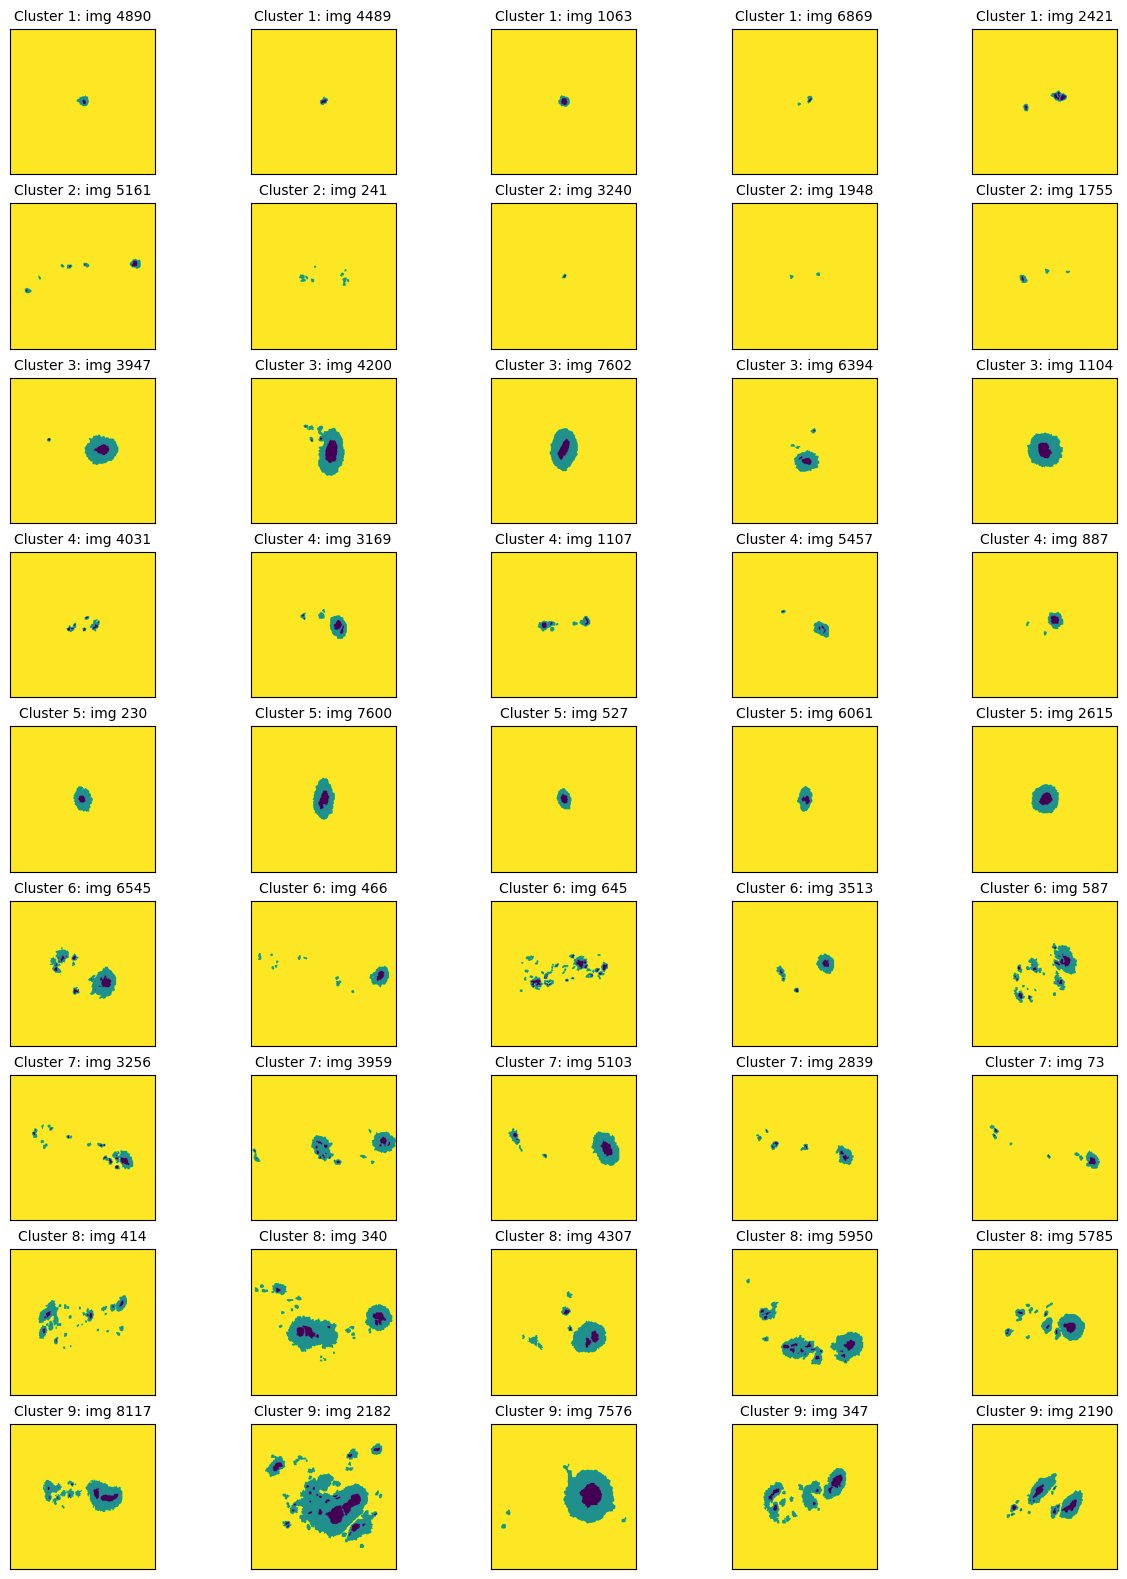

In [51]:
hier_clust = linkage(emb_pca, method='median')
distances = hier_clust[-15:, 2]
distances_sorted = sorted(distances, reverse=True)
hier_clust_labels = fcluster(hier_clust, t=9, criterion='maxclust')

clusters = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
for index, label in enumerate(hier_clust_labels):
    #print('img:',index, 'label:',label)
    for i in range(1, 10):
        if label == i:  #i-1(если labels [0,...,6]), i(если labels [1,...,7])
            clusters[i].append(index)
# выбираем случайным образом по 5 точек в каждый кластер
num_clusts = []
sampled_clusters = {}
x = 0
for cluster_num, indices in clusters.items():
    sampled_clusters[cluster_num] = random.choices(indices, k=5) #indices[0:5]   random.choices(indices, k=5)
    #print(f"Кластер {cluster_num}. Элементов: {len(indices)}")
    x += len(indices)
    num_clusts.append(len(indices))

index = FilesIndex(path='/kaggle/working/sunspot_dataset/*.npz', name='img').sort_index()
fig, ax = plt.subplots(len(set(hier_clust_labels)), len(sampled_clusters[1]), figsize=(15, 20))
fig.patch.set_facecolor('xkcd:white')

for i, (key, color_clust) in enumerate(sampled_clusters.items()):
    with torch.no_grad():
        batch = (HelioBatch(index.iloc[color_clust])
                 .load('img', sparse=True)
                 .apply(lambda x: x.toarray().reshape(256, 256, 3), src='img')
                 .apply(transform_channels, src='img'))
        x = torch.tensor(np.stack(batch.img)).to(device)

    for j in range(len(sampled_clusters[1])):
        ax[i][j].imshow(1-x[j,0].detach().cpu().numpy(),vmin=0, vmax=1)
        ax[i][j].set_title('Cluster {}: img {}'.format(key, color_clust[j]), fontsize=10)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

plt.show()